# 새로운 시작

In [1]:
from google.colab import drive
drive.mount('/gdrive')

%cd /gdrive/MyDrive/open/

Mounted at /gdrive
/gdrive/MyDrive/open


## 데이터 로딩 및 전처리

### Subtask:
이전 셀의 코드를 사용하여 데이터를 로드하고 전처리합니다. 범주형/수치형 컬럼을 사용자 요구사항에 맞게 재정의하고, 각 컬럼 타입에 맞는 스케일링 및 인코딩을 적용합니다. `seq` 컬럼은 문자열 그대로 유지합니다.


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Re-load data and perform initial downsampling as in previous cells
# 데이터 로드
all_train = pd.read_parquet("./train-001.parquet", engine="pyarrow")
test = pd.read_parquet("./test.parquet", engine="pyarrow").drop(columns=['ID'])


In [2]:
# clicked == 1 데이터
# clicked_1 = all_train[all_train['clicked'] == 1]

# clicked == 0 데이터에서 동일 개수x2 만큼 무작위 추출 (다운 샘플링)
# clicked_0 = all_train[all_train['clicked'] == 0].sample(n=len(clicked_1)*2, random_state=42)

# 두 데이터프레임 합치기
# train_df = pd.concat([clicked_1, clicked_0], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)

# Use the full training data without downsampling
train_df = all_train.sample(frac=1, random_state=42).reset_index(drop=True)


print("Train shape (after sampling):", train_df.shape)
print("Train clicked:0 (after sampling):", train_df[train_df['clicked']==0].shape)
print("Train clicked:1 (after sampling):", train_df[train_df['clicked']==1].shape)

# Target / Sequence
target_col = "clicked"
seq_col = "seq"


# --- Define Column Lists ---
# Define feature columns based on user requirements for ClickDataset and Model
# 범주형 컬럼: 'gender', 'age_group', 'inventory_id', 'day_of_week', 'hour', 'l_feat_*'
categorical_cols = ['gender', 'age_group', 'inventory_id', 'day_of_week', 'hour']
# Use columns from train_df to find 'l_feat_*' columns
categorical_cols.extend([c for c in train_df.columns if c.startswith('l_feat_') and c not in categorical_cols])

# 수치형 컬럼: 'feat_*_*', 'history_*_*'
# Exclude categorical, seq, target, and ID columns
numerical_cols_full = [c for c in train_df.columns if (c.startswith('feat_') or c.startswith('history_')) and c not in categorical_cols and c != seq_col and c != target_col and c != 'ID']

# Split numerical columns into feat_*_* and history_*_* as per model definition
numerical_feat_cols = [c for c in numerical_cols_full if c.startswith('feat_')]
numerical_history_cols = [c for c in numerical_cols_full if c.startswith('history_')]


# Ensure all non-excluded columns are categorized
all_defined_cols = set(categorical_cols + numerical_feat_cols + numerical_history_cols + [seq_col, target_col, 'ID'])
remaining_cols = [c for c in train_df.columns if c not in all_defined_cols]
if remaining_cols:
    print(f"Warning: The following columns are not categorized: {remaining_cols}")
    # Decide how to handle uncategorized columns - for now, warn and proceed
    # If they should be numerical, they should match the 'feat_*_*' or 'history_*_*' pattern

print("Categorical features:", categorical_cols)
print("Numerical feat_*_* features:", numerical_feat_cols)
print("Numerical history_*_* features:", numerical_history_cols)
print("Sequence feature:", seq_col)
print("Target feature:", target_col)


# Apply Label Encoding to categorical features using both train and test data
vocab_sizes = {}
for col in categorical_cols:
    # Use all unique values from both train and test for encoding
    all_categories = pd.concat([all_train[col], test[col]]).astype(str).unique() # Use original dataframes to get all categories
    vocab_sizes[col] = len(all_categories) + 1 # +1 for mask token
    # Label Encoding
    le = LabelEncoder()
    le.fit(all_categories)
    train_df[col] = le.transform(train_df[col].astype(str))
    test[col] = le.transform(test[col].astype(str))
    # Explicitly cast to integer type after encoding to prevent object dtype issues
    train_df[col] = train_df[col].astype(int)
    test[col] = test[col].astype(int)


print("Vocab sizes for categorical features:", vocab_sizes)

# Apply StandardScaler to numerical features
scaler = StandardScaler()
# Ensure numerical columns are numeric before scaling and handle NaNs if necessary
# StandardScaler handles NaNs by default in fit/transform, but explicit cast is good practice
train_df[numerical_feat_cols + numerical_history_cols] = scaler.fit_transform(train_df[numerical_feat_cols + numerical_history_cols]).astype(float)
test[numerical_feat_cols + numerical_history_cols] = scaler.transform(test[numerical_feat_cols + numerical_history_cols]).astype(float) # Transform test data using the scaler fitted on train

# Display head of processed dataframes to verify
print("\nTrain dataframe head after preprocessing:")
display(train_df.head())
print("\nTest dataframe head after preprocessing:")
display(test.head())

Train shape (after sampling): (10704179, 119)
Train clicked:0 (after sampling): (10500000, 119)
Train clicked:1 (after sampling): (204179, 119)
Categorical features: ['gender', 'age_group', 'inventory_id', 'day_of_week', 'hour', 'l_feat_1', 'l_feat_2', 'l_feat_3', 'l_feat_4', 'l_feat_5', 'l_feat_6', 'l_feat_7', 'l_feat_8', 'l_feat_9', 'l_feat_10', 'l_feat_11', 'l_feat_12', 'l_feat_13', 'l_feat_14', 'l_feat_15', 'l_feat_16', 'l_feat_17', 'l_feat_18', 'l_feat_19', 'l_feat_20', 'l_feat_21', 'l_feat_22', 'l_feat_23', 'l_feat_24', 'l_feat_25', 'l_feat_26', 'l_feat_27']
Numerical feat_*_* features: ['feat_e_1', 'feat_e_2', 'feat_e_3', 'feat_e_4', 'feat_e_5', 'feat_e_6', 'feat_e_7', 'feat_e_8', 'feat_e_9', 'feat_e_10', 'feat_d_1', 'feat_d_2', 'feat_d_3', 'feat_d_4', 'feat_d_5', 'feat_d_6', 'feat_c_1', 'feat_c_2', 'feat_c_3', 'feat_c_4', 'feat_c_5', 'feat_c_6', 'feat_c_7', 'feat_c_8', 'feat_b_1', 'feat_b_2', 'feat_b_3', 'feat_b_4', 'feat_b_5', 'feat_b_6', 'feat_a_1', 'feat_a_2', 'feat_a_3', 'f

,gender,age_group,inventory_id,day_of_week,hour,seq,l_feat_1,l_feat_2,l_feat_3,l_feat_4,...,history_b_22,history_b_23,history_b_24,history_b_25,history_b_26,history_b_27,history_b_28,history_b_29,history_b_30,clicked
0,1,5,10,4,0,"9,57,74,77,318,101,138,132,532,101,497,101,132...",1,1,1,16,...,-0.203959,-0.203077,-0.203050,-0.202894,-0.206206,-0.205745,-0.205610,-0.203102,-0.249577,0
1,0,7,9,5,18,"9,57,193,463,212,479,463,193,57,479,57,463,193...",1,1,2,23,...,-0.193529,-0.192640,-0.192613,-0.192457,-0.195783,-0.195321,-0.195182,-0.192665,-0.202376,0
2,0,5,9,4,7,"57,516,195,27,479,269,57,516,527,74,77,207,452...",1,1,2,0,...,-0.151865,-0.150951,-0.150923,-0.150770,-0.154154,-0.153684,-0.153525,-0.150976,-0.217258,0
3,1,3,12,2,19,"516,57,165,165,338,416,74,527,77,463,212,193,1...",1,1,2,23,...,-0.089010,-0.088057,-0.088029,-0.087880,-0.091349,-0.090870,-0.090681,-0.088083,-0.157317,0
4,1,7,14,0,23,"321,144,516,57,165,527,74,318,77,317,75,269,45...",1,1,1,22,...,-0.115892,-0.114956,-0.114928,-0.114778,-0.118210,-0.117735,-0.117558,-0.114981,-0.182953,0



Test dataframe head after preprocessing:


,gender,age_group,inventory_id,day_of_week,hour,seq,l_feat_1,l_feat_2,l_feat_3,l_feat_4,...,history_b_21,history_b_22,history_b_23,history_b_24,history_b_25,history_b_26,history_b_27,history_b_28,history_b_29,history_b_30
0,1,5,12,6,13,"321,269,57,516,479,516,57,479,35,57,516,403,45...",1,1,1,10,...,-0.185212,-0.186349,-0.185455,-0.185428,-0.185273,-0.188609,-0.188145,-0.188003,-0.185480,-0.147673
1,1,7,4,6,21,"57,35,479,57,463,212,193,151,463,193,74,77,207...",1,1,1,23,...,-0.119936,-0.121112,-0.120179,-0.120151,-0.120000,-0.123425,-0.122951,-0.122777,-0.120204,-0.187931
2,0,5,7,6,19,"57,516,97,74,527,77,318,315,317,311,269,479,57...",1,1,2,23,...,-0.131524,-0.132693,-0.131766,-0.131739,-0.131587,-0.134996,-0.134524,-0.134356,-0.131792,-0.198974
3,1,6,9,6,9,"144,321,57,479,57,479,35,57,516,165,74,527,318...",1,1,1,23,...,-0.193810,-0.167719,-0.194053,-0.194026,-0.193870,-0.197195,-0.196732,-0.196594,-0.194078,-0.232377
4,0,7,2,6,18,"269,57,516,342,516,403,173,457,343,403,457,173...",1,1,2,24,...,-0.194149,-0.195281,-0.194393,-0.194366,-0.194210,-0.197534,-0.197072,-0.196933,-0.194418,-0.233024


In [3]:
import numpy as np
import pandas as pd
import torch

def debug_dataset(train_df, categorical_cols, vocab_sizes, embedding_dims, transformer_heads):
    print("\n=== [1] NaN & Inf 체크 (수치형 컬럼만) ===")
    numeric_df = train_df.select_dtypes(include=[np.number])

    # NaN 확인
    nan_counts = numeric_df.isna().sum()
    nan_cols = nan_counts[nan_counts > 0]
    if len(nan_cols) > 0:
        print("⚠️ NaN detected in numeric columns:")
        print(nan_cols)
    else:
        print("✅ No NaN in numeric columns")

    # Inf 확인
    inf_mask = np.isinf(numeric_df.to_numpy())
    if inf_mask.any():
        print("⚠️ Inf detected in numeric columns")
        inf_cols = numeric_df.columns[np.any(np.isinf(numeric_df.to_numpy()), axis=0)]
        print("Columns with Inf:", list(inf_cols))
    else:
        print("✅ No Inf in numeric columns")

    # NaN/Inf 처리 예시 (선택적으로 실행)
    # train_df[numeric_df.columns] = numeric_df.fillna(0).replace([np.inf, -np.inf], 0)


    print("\n=== [2] Embedding 인덱스 범위 체크 ===")
    for col in categorical_cols:
        max_val = train_df[col].max()
        min_val = train_df[col].min()
        vocab_size = vocab_sizes[col]

        if max_val >= vocab_size:
            print(f"❌ {col}: max index {max_val} >= vocab size {vocab_size}")
        if min_val < 0:
            print(f"❌ {col}: min index {min_val} is negative")
    print("✅ Embedding index check complete.")


    print("\n=== [3] Transformer 설정 체크 ===")
    total_emb_dim = sum(embedding_dims[col] for col in categorical_cols)
    if total_emb_dim % transformer_heads != 0:
        print(f"❌ Transformer d_model ({total_emb_dim}) is not divisible by nhead ({transformer_heads})")
    else:
        print(f"✅ Transformer setting OK: d_model={total_emb_dim}, nhead={transformer_heads}")


    print("\n=== [4] Sequence 길이 체크 (0 길이 있는지) ===")
    if "seq" in train_df.columns:
        zero_seq_count = (train_df["seq"] == 0).sum()
        if zero_seq_count > 0:
            print(f"⚠️ Found {zero_seq_count} samples with seq_length = 0")
        else:
            print("✅ No zero-length sequences found")
    else:
        print("ℹ️ seq_length 컬럼이 데이터프레임에 없습니다 (별도로 seq_lengths 텐서를 확인하세요).")


    print("\n=== [5] embedding 크기를 벗어나는지 ===")
    for col in categorical_cols:
        max_idx = train_df[col].max()
        min_idx = train_df[col].min()
        if max_idx >= vocab_sizes[col]:
            print(f"❌ {col}: max index {max_idx} >= vocab size {vocab_sizes[col]}")
        if min_idx < 0:
            print(f"❌ {col}: min index {min_idx} < 0")
        else:
            print(f"✅ {col}: OK")

    print("\n=== [6] 샘플 값 확인 (상위 5개) ===")
    print(train_df.head(5)[categorical_cols[:5]])  # 범주형 일부 샘플
    print(numeric_df.head(5).iloc[:, :5])          # 수치형 일부 샘플

    print("\n🔎 디버깅 완료")
embedding_dims = {col: 16 for col in categorical_cols} # Example
debug_dataset(
    train_df=train_df,
    categorical_cols=categorical_cols,
    vocab_sizes=vocab_sizes,
    embedding_dims=embedding_dims,
    transformer_heads=4  # 모델 설정에 맞게 수정
)


# ======================================================================
import numpy as np
# 수치형 컬럼만 선택
numeric_cols = train_df.select_dtypes(include=[np.number]).columns
# NaN, Inf, -Inf → 0으로 일괄 처리
train_df[numeric_cols] = (
    train_df[numeric_cols]
    .fillna(0)
    .replace([np.inf, -np.inf], 0)
)
print("✅ NaN & Inf values in numeric columns have been cleaned.")
# NaN / Inf 다시 점검
print("NaN remaining:", train_df[numeric_cols].isna().sum().sum())
print("Inf remaining:", np.isinf(train_df[numeric_cols].to_numpy()).any())


=== [1] NaN & Inf 체크 (수치형 컬럼만) ===
⚠️ NaN detected in numeric columns:
feat_e_1          17208
feat_e_2          17208
feat_e_3        1085557
feat_e_4          17208
feat_e_5          17208
                 ...   
history_b_26      17208
history_b_27      17208
history_b_28      17208
history_b_29      17208
history_b_30      17208
Length: 85, dtype: int64
✅ No Inf in numeric columns

=== [2] Embedding 인덱스 범위 체크 ===
✅ Embedding index check complete.

=== [3] Transformer 설정 체크 ===
✅ Transformer setting OK: d_model=512, nhead=4

=== [4] Sequence 길이 체크 (0 길이 있는지) ===
✅ No zero-length sequences found

=== [5] embedding 크기를 벗어나는지 ===
✅ gender: OK
✅ age_group: OK
✅ inventory_id: OK
✅ day_of_week: OK
✅ hour: OK
✅ l_feat_1: OK
✅ l_feat_2: OK
✅ l_feat_3: OK
✅ l_feat_4: OK
✅ l_feat_5: OK
✅ l_feat_6: OK
✅ l_feat_7: OK
✅ l_feat_8: OK
✅ l_feat_9: OK
✅ l_feat_10: OK
✅ l_feat_11: OK
✅ l_feat_12: OK
✅ l_feat_13: OK
✅ l_feat_14: OK
✅ l_feat_15: OK
✅ l_feat_16: OK
✅ l_feat_17: OK
✅ l_feat_18: OK
✅ l_f

## Dataset 및 DataLoader 수정

### Subtask:
새로운 모델 구조에 맞게 `ClickDataset` 클래스를 수정하거나 새로 정의합니다. 특히 `seq` 데이터를 시퀀스 형태로 처리하고, 다른 피처들을 분리하여 반환하도록 합니다. Collate 함수도 수정하여 `seq` 데이터 패딩 및 길이를 처리합니다.

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.utils.rnn as rnn_utils
import numpy as np
import pandas as pd

class ClickDataset(Dataset):
    def __init__(self, df, categorical_cols, numerical_feat_cols, numerical_history_cols, seq_col, target_col=None, has_target=True):
        self.df = df.reset_index(drop=True)
        self.categorical_cols = categorical_cols
        self.numerical_feat_cols = numerical_feat_cols
        self.numerical_history_cols = numerical_history_cols
        self.seq_col = seq_col
        self.target_col = target_col
        self.has_target = has_target

        if self.has_target:
            self.y = self.df[self.target_col].astype(np.float32).values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get categorical features
        # Add explicit astype(int) before converting to tensor
        cat_features = torch.tensor(self.df.loc[idx, self.categorical_cols].values.astype(int), dtype=torch.long)

        # Get numerical 'feat_*_*' features
        # Add explicit astype(float) before converting to tensor
        num_feat_features = torch.tensor(self.df.loc[idx, self.numerical_feat_cols].values.astype(float), dtype=torch.float)

        # Get numerical 'history_*_*' features
        # Add explicit astype(float) before converting to tensor
        num_history_features = torch.tensor(self.df.loc[idx, self.numerical_history_cols].values.astype(float), dtype=torch.float)

        # Get sequence feature (parse string)
        seq_string = self.df.loc[idx, self.seq_col]
        if isinstance(seq_string, str) and seq_string:
            try:
                seq_array = np.fromstring(seq_string, sep=",", dtype=np.float32)
            except ValueError:
                seq_array = np.array([0.0], dtype=np.float32)
        else:
            seq_array = np.array([0.0], dtype=np.float32) # Handle None, NaN, or empty strings

        seq_tensor = torch.from_numpy(seq_array)

        if self.has_target:
            y = torch.tensor(self.y[idx], dtype=torch.float)
            return cat_features, num_feat_features, num_history_features, seq_tensor, y
        else:
            return cat_features, num_feat_features, num_history_features, seq_tensor


def collate_fn_train(batch):
    # Batch is a list of tuples: [(cat_features_1, num_feat_1, num_history_1, seq_1, y_1), ...]
    cat_features, num_feat_features, num_history_features, seqs, ys = zip(*batch)

    cat_features = torch.stack(cat_features)
    num_feat_features = torch.stack(num_feat_features)
    num_history_features = torch.stack(num_history_features)
    ys = torch.stack(ys).unsqueeze(1) # Add dimension for BCEWithLogitsLoss

    # Pad sequences
    seqs_padded = rnn_utils.pad_sequence(seqs, batch_first=True, padding_value=0.0)
    seq_lengths = torch.tensor([len(s) for s in seqs], dtype=torch.long)
    seq_lengths = torch.clamp(seq_lengths, min=1) # Ensure minimum length is 1 for non-empty sequences


    return cat_features, num_feat_features, num_history_features, seqs_padded, seq_lengths, ys


def collate_fn_infer(batch):
    # Batch is a list of tuples: [(cat_features_1, num_feat_1, num_history_1, seq_1), ...]
    cat_features, num_feat_features, num_history_features, seqs = zip(*batch)

    cat_features = torch.stack(cat_features)
    num_feat_features = torch.stack(num_feat_features)
    num_history_features = torch.stack(num_history_features)


    # Pad sequences
    seqs_padded = rnn_utils.pad_sequence(seqs, batch_first=True, padding_value=0.0)
    seq_lengths = torch.tensor([len(s) for s in seqs], dtype=torch.long)
    seq_lengths = torch.clamp(seq_lengths, min=1) # Ensure minimum length is 1 for non-empty sequences

    return cat_features, num_feat_features, num_history_features, seqs_padded, seq_lengths

## 모델 구조 정의

### Subtask:
사용자 요구사항에 맞춰 새로운 `ComplexModel` 클래스를 정의합니다. 이 클래스 안에는 다음 서브 모듈이 포함됩니다.
- 범주형 피처를 위한 임베딩 레이어와 Transformer Encoder.
- 시퀀스 데이터 처리를 위한 LSTM.
- `feat_*_*` 수치형 피처를 위한 MLP.
- `history_*_*` 수치형 피처를 위한 MLP.
- 모든 서브 모듈의 출력을 결합하고 최종 예측을 수행하는 MLP.

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ComplexModel(nn.Module):
    def __init__(self, vocab_sizes, embedding_dims, numerical_feat_dim, numerical_history_dim,
                 lstm_hidden_dim=64, lstm_n_layers = 2, transformer_heads=4, transformer_layers=2,
                 mlp_hidden_units=[256, 128], final_mlp_hidden_units=[512, 256, 128], dropout=0.2):
        super().__init__()

        # 1. 범주형 피처 처리 (Embedding + Transformer)
        self.embedding_layers = nn.ModuleDict({col: nn.Embedding(vocab_sizes[col], embedding_dims[col]) for col in vocab_sizes.keys()})
        total_categorical_embedding_dim = sum(emb.embedding_dim for emb in self.embedding_layers.values())

        # 1-1. 트랜스포머 적용 Transformer Encoder - expects (batch_size, sequence_length, d_model)
        # For tabular data, we treat each sample as a sequence of length 1 for Transformer
        transformer_d_model = total_categorical_embedding_dim # d_model should match input dim
        encoder_layer = nn.TransformerEncoderLayer(d_model=transformer_d_model, nhead=transformer_heads, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=transformer_layers)

        # 2. 시퀀스 피처 처리 (LSTM)
        self.lstm = nn.LSTM(input_size=1,num_layers= lstm_n_layers, hidden_size=lstm_hidden_dim, batch_first=True)


        # 3. 수치형 'feat_*_*' 피처 처리 (MLP)
        feat_mlp_layers = []
        input_dim_feat_mlp = numerical_feat_dim
        for h in mlp_hidden_units:
            feat_mlp_layers += [nn.Linear(input_dim_feat_mlp, h), nn.ReLU(), nn.Dropout(dropout)]
            input_dim_feat_mlp = h
        self.feat_mlp = nn.Sequential(*feat_mlp_layers)
        feat_mlp_output_dim = mlp_hidden_units[-1] if mlp_hidden_units else numerical_feat_dim # Output dim of feat_mlp


        # 4. 수치형 'history_*_*' 피처 처리 (MLP)
        history_mlp_layers = []
        input_dim_history_mlp = numerical_history_dim
        for h in mlp_hidden_units:
            history_mlp_layers += [nn.Linear(input_dim_history_mlp, h), nn.ReLU(), nn.Dropout(dropout)]
            input_dim_history_mlp = h
        self.history_mlp = nn.Sequential(*history_mlp_layers)
        history_mlp_output_dim = mlp_hidden_units[-1] if mlp_hidden_units else numerical_history_dim # Output dim of history_mlp


        # 5. 최종 결합 및 예측 (MLP)
        # Input dimension = LSTM output + feat_mlp output + history_mlp output + Transformer output
        # LSTM output is lstm_hidden_dim (from last hidden state)
        # Transformer output is transformer_d_model (when sequence_length=1)
        final_mlp_input_dim = lstm_hidden_dim + feat_mlp_output_dim + history_mlp_output_dim + transformer_d_model


        final_layers = []
        input_dim_final_mlp = final_mlp_input_dim
        for h in final_mlp_hidden_units:
             final_layers += [nn.Linear(input_dim_final_mlp, h), nn.ReLU(), nn.Dropout(dropout)]
             input_dim_final_mlp = h
        final_layers += [nn.Linear(input_dim_final_mlp, 1)] # Output layer for binary classification (logits)
        self.final_mlp = nn.Sequential(*final_layers)


    def forward(self, cat_x, num_feat_x, num_history_x, seq_x, seq_lengths):
        # 1. 범주형 피처 처리
        embeddings = [self.embedding_layers[col](cat_x[:, i]) for i, col in enumerate(categorical_cols)] # Use global categorical_cols
        cat_embedded = torch.cat(embeddings, dim=1) # (B, total_categorical_embedding_dim)

        # 1-1. 트랜스포머 적용 Transformer requires (B, L, D), here L=1
        cat_transformer_input = cat_embedded.unsqueeze(1) # (B, 1, total_categorical_embedding_dim)
        transformer_output = self.transformer_encoder(cat_transformer_input).squeeze(1) # (B, total_categorical_embedding_dim)


        # 2. 시퀀스 피처 처리
        # LSTM requires (B, L, 1) input for scalar sequence, and packed sequence
        seq_x = seq_x.unsqueeze(-1) # (B, L, 1)
        packed_seq = rnn_utils.pack_padded_sequence(seq_x, seq_lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (h_n, _) = self.lstm(packed_seq)
        lstm_output = h_n[-1] # (B, lstm_hidden_dim) - last hidden state of the last layer


        # 3. 수치형 'feat_*_*' 피처 처리
        feat_mlp_output = self.feat_mlp(num_feat_x) # (B, feat_mlp_output_dim)


        # 4. 수치형 'history_*_*' 피처 처리
        history_mlp_output = self.history_mlp(num_history_x) # (B, history_mlp_output_dim)


        # 5. 모든 출력을 결합
        combined_features = torch.cat([
            lstm_output,
            feat_mlp_output,
            history_mlp_output,
            transformer_output # Combine Transformer output
        ], dim=1) # (B, final_mlp_input_dim)


        # 최종 예측 MLP
        logits = self.final_mlp(combined_features).squeeze(1) # (B,) - logits for BCEWithLogitsLoss

        return logits



# score 함수

from sklearn.metrics import average_precision_score
import numpy as np # Import numpy

def calculate_weighted_logloss(y_true, y_pred, eps=1e-15):
    """Calculate Weighted LogLoss with 50:50 class weights"""
    y_pred = np.clip(y_pred, eps, 1 - eps)

    mask_0 = (y_true == 0)
    mask_1 = (y_true == 1)

    ll_0 = -np.mean(np.log(1 - y_pred[mask_0])) if mask_0.sum() > 0 else 0
    ll_1 = -np.mean(np.log(y_pred[mask_1])) if mask_1.sum() > 0 else 0

    return 0.5 * ll_0 + 0.5 * ll_1

def calculate_competition_score(y_true, y_pred):
    """Calculate competition score: 0.5*AP + 0.5*(1/(1+WLL))"""
    ap = average_precision_score(y_true, y_pred)
    wll = calculate_weighted_logloss(y_true, y_pred)
    score = 0.5 * ap + 0.5 * (1 / (1 + wll))
    return score, ap, wll

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os # Import os for saving/loading models
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR # Import schedulers

def train_complex_model(train_df, categorical_cols, numerical_feat_cols, numerical_history_cols, seq_col, target_col,
                         vocab_sizes, embedding_dims, lstm_hidden_dims = 64, lstm_layers = 2, transformer_n_heads=4, transformer_n_layers=2,
                        mlp_hidden_n_units=[256, 128], final_mlp_hidden_n_units=[512, 256, 128], n_dropout=0.2, batch_size=512, epochs=3, lr=1e-3, device="cuda"):

    tr_df, va_df = train_test_split(train_df, test_size=0.2, random_state=42, shuffle=True)

    train_dataset = ClickDataset(tr_df, categorical_cols, numerical_feat_cols, numerical_history_cols, seq_col, target_col, has_target=True)
    val_dataset   = ClickDataset(va_df, categorical_cols, numerical_feat_cols, numerical_history_cols, seq_col, target_col, has_target=True)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  collate_fn=collate_fn_train, num_workers=2) # Add num_workers for faster loading
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, collate_fn=collate_fn_train, num_workers=2)

    numerical_feat_dim = len(numerical_feat_cols)
    numerical_history_dim = len(numerical_history_cols)


    model = ComplexModel(
        vocab_sizes=vocab_sizes,
        embedding_dims=embedding_dims,
        numerical_feat_dim=numerical_feat_dim,
        numerical_history_dim=numerical_history_dim,
        lstm_hidden_dim= lstm_hidden_dims,
        lstm_n_layers = lstm_layers,
        transformer_heads=transformer_n_heads,
        transformer_layers=transformer_n_layers,
        mlp_hidden_units=mlp_hidden_n_units,
        final_mlp_hidden_units=final_mlp_hidden_n_units,
        dropout=n_dropout
    ).to(device)

    # Calculate pos_weight for BCEWithLogitsLoss
    # Count positive and negative samples in the training data
    pos_count = tr_df[target_col].sum()
    neg_count = len(tr_df) - pos_count
    pos_weight = torch.tensor(neg_count / pos_count, dtype=torch.float32).to(device)

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight) # Use pos_weight
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr) # Use AdamW optimizer

    # Learning Rate Scheduler
    # scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True) # Reduce LR based on validation competition score
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0) # Use Cosine Annealing LR

    # Lists to store loss and scores for visualization
    train_losses = []
    val_losses = []
    train_ap_scores = []
    val_ap_scores = []
    train_wll_scores = []
    val_wll_scores = []
    train_comp_scores = []
    val_comp_scores = []

    best_val_comp_score = -float('inf')
    best_model_state_dict = None
    model_save_path = './T2G_best_model.pth' # Define a path to save the best model


    print(f"--- Starting Training ---")
    for epoch in range(1, epochs+1):
        model.train()
        train_loss = 0.0
        train_preds = []
        train_true = []
        for cat_features, num_feat_features, num_history_features, seqs_padded, seq_lengths, ys in tqdm(train_loader, desc=f"Train Epoch {epoch}"):
            # to device (범주형, 수치형1, 수치형2, seq, clicked)
            cat_features, num_feat_features, num_history_features, seqs_padded, seq_lengths, ys = cat_features.to(device), num_feat_features.to(device), num_history_features.to(device),seqs_padded.to(device), seq_lengths.to(device), ys.to(device)

            optimizer.zero_grad()

            logits = model(cat_features, num_feat_features, num_history_features, seqs_padded, seq_lengths)
            loss = criterion(logits, ys.squeeze(1)) # Remove extra dimension from ys

            loss.backward()
            optimizer.step()
            train_loss += loss.item() * ys.size(0)

            train_preds.append(torch.sigmoid(logits).detach().cpu().numpy())
            train_true.append(ys.squeeze(1).cpu().numpy())


        train_loss /= len(train_dataset)
        train_preds = np.concatenate(train_preds)
        train_true = np.concatenate(train_true)

        train_comp_score, train_ap, train_wll = calculate_competition_score(train_true, train_preds)

        train_losses.append(train_loss)
        train_ap_scores.append(train_ap)
        train_wll_scores.append(train_wll)
        train_comp_scores.append(train_comp_score)


        model.eval()
        val_loss = 0.0
        val_preds = []
        val_true = []
        with torch.no_grad():
            # Unpack the batch correctly according to collate_fn_train
            for cat_features, num_feat_features, num_history_features, seqs_padded, seq_lengths, ys in tqdm(val_loader, desc=f"Val Epoch {epoch}"):
                 # Move data to device
                 cat_features, num_feat_features, num_history_features, seqs_padded, seq_lengths, ys = \
                    cat_features.to(device), num_feat_features.to(device), num_history_features.to(device), \
                    seqs_padded.to(device), seq_lengths.to(device), ys.to(device)

                 # Pass correct inputs to the ComplexModel
                 logits = model(cat_features, num_feat_features, num_history_features, seqs_padded, seq_lengths)
                 loss = criterion(logits, ys.squeeze(1)) # Remove extra dimension from ys
                 val_loss += loss.item() * len(ys)

                 val_preds.append(torch.sigmoid(logits).cpu().numpy())
                 val_true.append(ys.squeeze(1).cpu().numpy())


        val_loss /= len(val_dataset)
        val_preds = np.concatenate(val_preds)
        val_true = np.concatenate(val_true)

        val_comp_score, val_ap, val_wll = calculate_competition_score(val_true, val_preds)

        val_losses.append(val_loss)
        val_ap_scores.append(val_ap)
        val_wll_scores.append(val_wll)
        val_comp_scores.append(val_comp_score)

        # Step the scheduler based on validation competition score
        # scheduler.step(val_comp_score) # ReduceLROnPlateau steps based on metric
        scheduler.step() # Cosine Annealing steps per epoch


        # Save best model based on validation competition score
        if val_comp_score > best_val_comp_score:
            best_val_comp_score = val_comp_score
            best_model_state_dict = model.state_dict()
            print(f"--- New best validation score: {best_val_comp_score:.4f}. Saving model ---")
            torch.save(best_model_state_dict, model_save_path)


        print(f"[Epoch {epoch}] Train Loss: {train_loss:.4f} | Train Comp Score: {train_comp_score:.4f} (AP: {train_ap:.4f}, WLL: {train_wll:.4f}) | Val Loss: {val_loss:.4f} | Val Comp Score: {val_comp_score:.4f} (AP: {val_ap:.4f}, WLL: {val_wll:.4f})")

    # Load the best model state dict after training finishes
    if best_model_state_dict:
        model.load_state_dict(best_model_state_dict)
        print(f"--- Loaded best model state dict with validation competition score: {best_val_comp_score:.4f} ---")
    else:
         print("--- No best model state dict saved. Using the last epoch's model. ---")


    return model, {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_ap_scores': train_ap_scores,
        'val_ap_scores': val_ap_scores,
        'train_wll_scores': train_wll_scores,
        'val_wll_scores': val_wll_scores,
        'train_comp_scores': train_comp_scores,
        'val_comp_scores': val_comp_scores
    }

## 모델 학습, 추론 및 제출 파일 생성 (컬럼 목록 정의 포함)

### Subtask:
정의된 `ComplexModel`을 사용하여 모델을 학습하고, 학습된 모델로 테스트 데이터에 대한 추론을 수행하여 제출 파일을 생성합니다. 필요한 컬럼 목록 변수들을 이 셀 내에서 명확히 정의합니다.

In [7]:
CFG = {
    'BATCH_SIZE': 1024,
    'EPOCHS': 5,
    'LEARNING_RATE': 1e-3,
    'SEED' : 42,
    'lstm_hidden_dims' : 64,
    'lstm_layers':2,
    'transformer_n_heads':4,
    'transformer_n_layers':2,
    'mlp_hidden_n_units':[256, 128],
    'final_mlp_hidden_n_units' : [512, 256, 128],
    'n_dropout' : 0.2
}

embedding_dims = {col: 16 for col in categorical_cols} # Example
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'device : {device}')

device : cuda


In [8]:
model, history = train_complex_model(
            train_df=train_df,
            categorical_cols=categorical_cols,
            numerical_feat_cols=numerical_feat_cols,
            numerical_history_cols=numerical_history_cols,
            seq_col=seq_col,
            target_col=target_col,
            vocab_sizes=vocab_sizes,
            embedding_dims=embedding_dims,
            lstm_hidden_dims = CFG['lstm_hidden_dims'],
            lstm_layers = CFG['lstm_layers'],
            transformer_n_heads=CFG['transformer_n_heads'],
            transformer_n_layers=CFG['transformer_n_layers'],
            mlp_hidden_n_units=CFG['mlp_hidden_n_units'],
            final_mlp_hidden_n_units=CFG['final_mlp_hidden_n_units'],
            n_dropout=CFG['n_dropout'],
            batch_size=CFG['BATCH_SIZE'],
            epochs=CFG['EPOCHS'],
            lr=CFG['LEARNING_RATE'],
            device=device
        )

--- Starting Training ---


Train Epoch 1: 100%|██████████| 8363/8363 [29:35<00:00,  4.71it/s]
/tmp/ipykernel_833701/4289709128.py:115: RuntimeWarning: divide by zero encountered in log
  ll_0 = -np.mean(np.log(1 - y_pred[mask_0])) if mask_0.sum() > 0 else 0
Val Epoch 1: 100%|██████████| 2091/2091 [07:18<00:00,  4.77it/s]


--- New best validation score: 0.3334. Saving model ---
[Epoch 1] Train Loss: 1.2647 | Train Comp Score: 0.0251 (AP: 0.0502, WLL: inf) | Val Loss: 1.2589 | Val Comp Score: 0.3334 (AP: 0.0570, WLL: 0.6397)


Train Epoch 2: 100%|██████████| 8363/8363 [29:57<00:00,  4.65it/s]
/tmp/ipykernel_833701/4289709128.py:115: RuntimeWarning: divide by zero encountered in log
  ll_0 = -np.mean(np.log(1 - y_pred[mask_0])) if mask_0.sum() > 0 else 0
Val Epoch 2: 100%|██████████| 2091/2091 [07:17<00:00,  4.78it/s]


--- New best validation score: 0.3346. Saving model ---
[Epoch 2] Train Loss: 1.2575 | Train Comp Score: 0.0263 (AP: 0.0526, WLL: inf) | Val Loss: 1.2528 | Val Comp Score: 0.3346 (AP: 0.0581, WLL: 0.6367)


Train Epoch 3: 100%|██████████| 8363/8363 [29:46<00:00,  4.68it/s]
/tmp/ipykernel_833701/4289709128.py:115: RuntimeWarning: divide by zero encountered in log
  ll_0 = -np.mean(np.log(1 - y_pred[mask_0])) if mask_0.sum() > 0 else 0
Val Epoch 3: 100%|██████████| 2091/2091 [07:16<00:00,  4.79it/s]


[Epoch 3] Train Loss: 1.2544 | Train Comp Score: 0.0267 (AP: 0.0533, WLL: inf) | Val Loss: 1.2533 | Val Comp Score: 0.3337 (AP: 0.0565, WLL: 0.6368)


Train Epoch 4: 100%|██████████| 8363/8363 [29:51<00:00,  4.67it/s]
/tmp/ipykernel_833701/4289709128.py:115: RuntimeWarning: divide by zero encountered in log
  ll_0 = -np.mean(np.log(1 - y_pred[mask_0])) if mask_0.sum() > 0 else 0
Val Epoch 4: 100%|██████████| 2091/2091 [07:18<00:00,  4.76it/s]


--- New best validation score: 0.3351. Saving model ---
[Epoch 4] Train Loss: 1.2505 | Train Comp Score: 0.0274 (AP: 0.0547, WLL: inf) | Val Loss: 1.2516 | Val Comp Score: 0.3351 (AP: 0.0589, WLL: 0.6360)


Train Epoch 5: 100%|██████████| 8363/8363 [29:44<00:00,  4.69it/s]
/tmp/ipykernel_833701/4289709128.py:115: RuntimeWarning: divide by zero encountered in log
  ll_0 = -np.mean(np.log(1 - y_pred[mask_0])) if mask_0.sum() > 0 else 0
Val Epoch 5: 100%|██████████| 2091/2091 [07:16<00:00,  4.79it/s]


--- New best validation score: 0.3355. Saving model ---
[Epoch 5] Train Loss: 1.2472 | Train Comp Score: 0.0280 (AP: 0.0560, WLL: inf) | Val Loss: 1.2516 | Val Comp Score: 0.3355 (AP: 0.0598, WLL: 0.6359)
--- Loaded best model state dict with validation competition score: 0.3355 ---


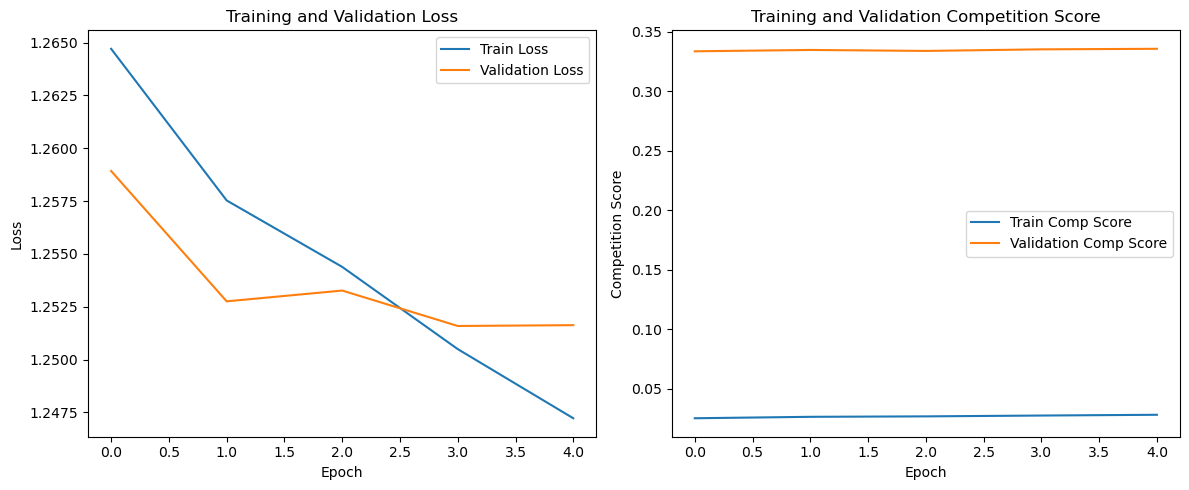

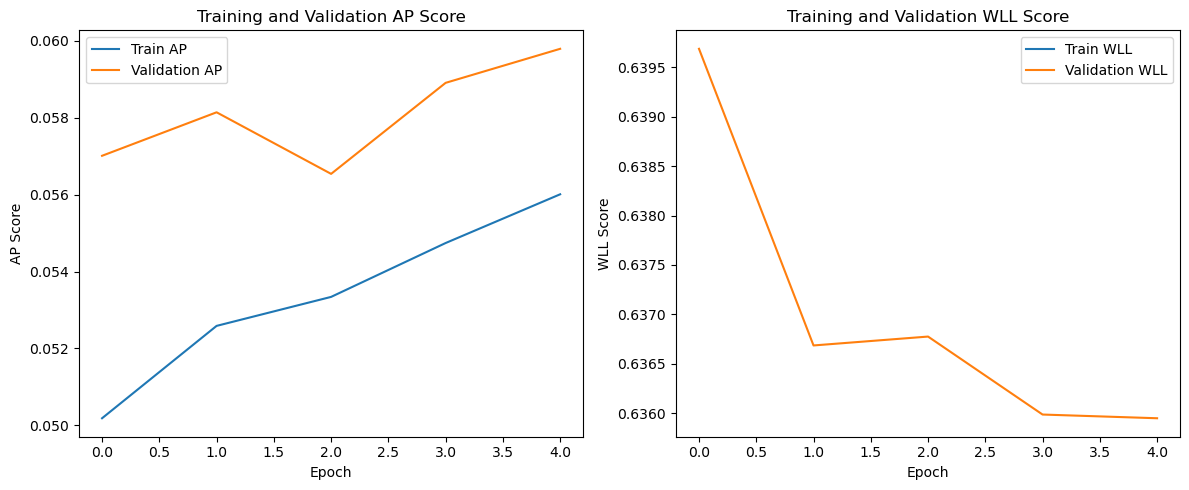

In [9]:
import matplotlib.pyplot as plt

# Plotting Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_losses'], label='Train Loss')
plt.plot(history['val_losses'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting Competition Score
plt.subplot(1, 2, 2)
plt.plot(history['train_comp_scores'], label='Train Comp Score')
plt.plot(history['val_comp_scores'], label='Validation Comp Score')
plt.xlabel('Epoch')
plt.ylabel('Competition Score')
plt.title('Training and Validation Competition Score')
plt.legend()

plt.tight_layout()
plt.show()

# Optional: Plotting AP and WLL separately
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_ap_scores'], label='Train AP')
plt.plot(history['val_ap_scores'], label='Validation AP')
plt.xlabel('Epoch')
plt.ylabel('AP Score')
plt.title('Training and Validation AP Score')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_wll_scores'], label='Train WLL')
plt.plot(history['val_wll_scores'], label='Validation WLL')
plt.xlabel('Epoch')
plt.ylabel('WLL Score')
plt.title('Training and Validation WLL Score')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
import numpy as np

print("\n--- Checking Test Data for Missing Values and Infinite Values ---")

# 결측값 확인 및 0으로 채우기 (결측값이 있을 경우에만)
print("--- Filling missing values with 0 in the test data (if any) ---")
initial_missing_values = test.isnull().sum().sum()

if initial_missing_values > 0:
    test.fillna(0, inplace=True)
    remaining_missing_values = test.isnull().sum().sum()
    print(f"✅ Filled {initial_missing_values - remaining_missing_values} missing values with 0.")
    if remaining_missing_values > 0:
        print(f"⚠️ Still detected {remaining_missing_values} missing values after filling.")
else:
    print("✅ No missing values found initially in the test data.")


# 무한대 값 확인 (수치형 컬럼만)
# 수치형 컬럼 선택
test_numeric_cols = test.select_dtypes(include=[np.number])
test_inf_values = np.isinf(test_numeric_cols.to_numpy()).sum()

if test_inf_values > 0:
    print(f"⚠️ Detected {test_inf_values} infinite values in the numeric columns of the test data.")
    # 무한대 값이 있는 컬럼 확인 (선택 사항)
    inf_cols_test = test_numeric_cols.columns[np.any(np.isinf(test_numeric_cols.to_numpy()), axis=0)]
    print("Columns with infinite values:", list(inf_cols_test))
else:
    print("✅ No infinite values found in the numeric columns of the test data.")

print("--- Test Data Check Complete ---")


print("\n--- Checking for empty sequences in 'seq' column ---")
# 'seq' 컬럼에서 빈 문자열 또는 NaN/None 값 찾기
empty_seq_count = test['seq'].astype(str).apply(lambda x: not bool(x.strip())).sum()

if empty_seq_count > 0:
    print(f"⚠️ Found {empty_seq_count} empty sequences in the 'seq' column.")
else:
    print("✅ No empty sequences found in the 'seq' column.")
print("--- Empty sequence check complete ---")


--- Checking Test Data for Missing Values and Infinite Values ---
--- Filling missing values with 0 in the test data (if any) ---
✅ Filled 173057 missing values with 0.
✅ No infinite values found in the numeric columns of the test data.
--- Test Data Check Complete ---

--- Checking for empty sequences in 'seq' column ---
✅ No empty sequences found in the 'seq' column.
--- Empty sequence check complete ---


In [11]:
import torch
import pandas as pd
from torch.utils.data import DataLoader
from tqdm import tqdm

print("--- Starting Inference ---")

# 1) Dataset/Loader for test data
test_dataset = ClickDataset(test, categorical_cols, numerical_feat_cols, numerical_history_cols, seq_col, has_target=False)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, collate_fn=collate_fn_infer, num_workers=2)

# 2) Predict
model.eval()
outs = []
with torch.no_grad():
    for cat_features, num_feat_features, num_history_features, seqs_padded, seq_lengths in tqdm(test_loader, desc="Inference"):
        cat_features, num_feat_features, num_history_features, seqs_padded, seq_lengths = \
            cat_features.to(device), num_feat_features.to(device), num_history_features.to(device), \
            seqs_padded.to(device), seq_lengths.to(device)

        logits = model(cat_features, num_feat_features, num_history_features, seqs_padded, seq_lengths)
        predictions = torch.sigmoid(logits).cpu()
        outs.append(predictions)

test_preds = torch.cat(outs).numpy()

# 3) Generate submission file
submit = pd.read_csv('./sample_submission.csv')
submit['clicked'] = test_preds
submit.to_csv('./T2G_submission.csv', index=False)
print("Submission file 'complex_model_inference_submission.csv' created successfully.")

--- Starting Inference ---


Inference: 100%|██████████| 1492/1492 [05:03<00:00,  4.91it/s]


Submission file 'complex_model_inference_submission.csv' created successfully.


In [12]:
import pandas as pd
# 이전에 실행된 코드 (모델 추론 및 제출 파일 생성)는 여기에 유지됩니다.

# --- 추가된 코드: 제출 파일 결측값 확인 ---
print("\n--- Checking Submission File for Missing Values ---")
submit_df = pd.read_csv('./T2G_submission.csv')

# 'clicked' 컬럼에 결측값이 있는지 확인
missing_values_count = submit_df['clicked'].isnull().sum()

if missing_values_count > 0:
    print(f"⚠️ Detected {missing_values_count} missing values in the 'clicked' column of RaTab_submission.csv")
else:
    print("✅ No missing values found in the 'clicked' column of RaTab_submission.csv")

# 전체 데이터프레임에 걸쳐 결측값 확인 (참고용)
total_missing_all_cols = submit_df.isnull().sum().sum()
if total_missing_all_cols > 0:
     print(f"⚠️ Detected {total_missing_all_cols} missing values in total across all columns in RaTab_submission.csv")
else:
     print("✅ No missing values found across all columns in RaTab_submission.csv")


--- Checking Submission File for Missing Values ---
✅ No missing values found in the 'clicked' column of RaTab_submission.csv
✅ No missing values found across all columns in RaTab_submission.csv
